## Neural network workflow

This notebook describes the workflow for training neural networks

In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
import datetime
import models
import platform

from os.path import expanduser
from os import path
import logging

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn_evaluation import plot as sk_plot

import yass
from yass import read_config, preprocess, detect
from yass import util
from yass.augment import make
from yass.neuralnetwork import NeuralNetDetector, NeuralNetTriage, AutoEncoder 
from yass.explore import RecordingExplorer, SpikeTrainExplorer
from yass.templates import TemplatesProcessor

import numpy as np
from scipy.io import loadmat

from dstools import plot
from dstools.reproducibility import make_filename

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

LOCAL = platform.system() == 'Darwin'

# logging.basicConfig(level=logging.DEBUG)

In [3]:
# for reference
print('YASS version is: {}'.format(util.get_version()))

YASS version is: a675fa6 bypassing ae training


In [6]:
if LOCAL:
    yass.set_config("../config/49-local.yaml")
else:
    yass.set_config("../config/49-lab.yaml")

CONFIG = read_config()

In [7]:
path_to_data = path.expanduser('~/data')
path_to_ground_truth = path.join(path_to_data,
                                 'groundtruth_ej49_data1_set1.mat')
path_to_experiment = path.join(path_to_data, 'nnet')
path_to_standarized = path.join(path_to_experiment,
                                'preprocess', 'standarized.bin')
path_to_geom = path.join(path_to_data, 'ej49_geometry1.txt')

if LOCAL:
    path_to_here = path.expanduser('~/dev/lab/private-yass/nnet')
else:
    path_to_here = path.expanduser('~/dev/private-yass/nnet')

In [8]:
# load ground truth
_ = loadmat(path_to_ground_truth)
spike_train = np.hstack([_['spt_gt'], _['L_gt']])

# remove spikes at the beginning (2) and end (1) to avoid errors
# when getting waveforms
spike_train = spike_train[2:-1]

# shift ids to start at 0
spike_train[:, 1] = spike_train[:, 1] - 1

# compensate alignment
spike_train[:, 0] = spike_train[:, 0] + 10

In [9]:
def filename(extension=None):
    """Generate a valid directory name with the current datetime
    """
    now = datetime.datetime.now()
    name =  now.strftime('%d-%b-%Y@%H-%M-%S')
    
    if extension is not None:
        name += '.'+extension
    
    return name

## Visualizing templates

In [10]:
# use all templates
n_templates = np.max(spike_train[:,1]) + 1
chosen_templates_indexes = np.arange(n_templates)

# chosen_templates = [0, 1, 2, 3, 4, 5, 7, 8, 9, 11,
#                     12, 13, 14, 15, 16, 17, 18, 19,
#                     22, 23, 24, 25, 26, 27, 28, 29,
#                     30, 31, 32, 33, 34, 35, 36, 37,
#                     38, 39, 41, 42, 43, 44, 45, 46,
#                     47, 48]

In [11]:
# load 4x templates
processor = TemplatesProcessor.from_spike_train(CONFIG,
                                                4 * CONFIG.spike_size,
                                                spike_train,
                                                path_to_standarized)

processor.choose_with_indexes(chosen_templates_indexes, inplace=True)
processor.choose_with_minimum_amplitude(4, inplace=True)

templates_uncropped = processor.templates

processor.align(CONFIG.spike_size, inplace=True)
templates = (processor.crop_spatially(CONFIG.neigh_channels, CONFIG.geom)
             .values)

100%|██████████| 3/3 [00:22<00:00,  7.50s/it]


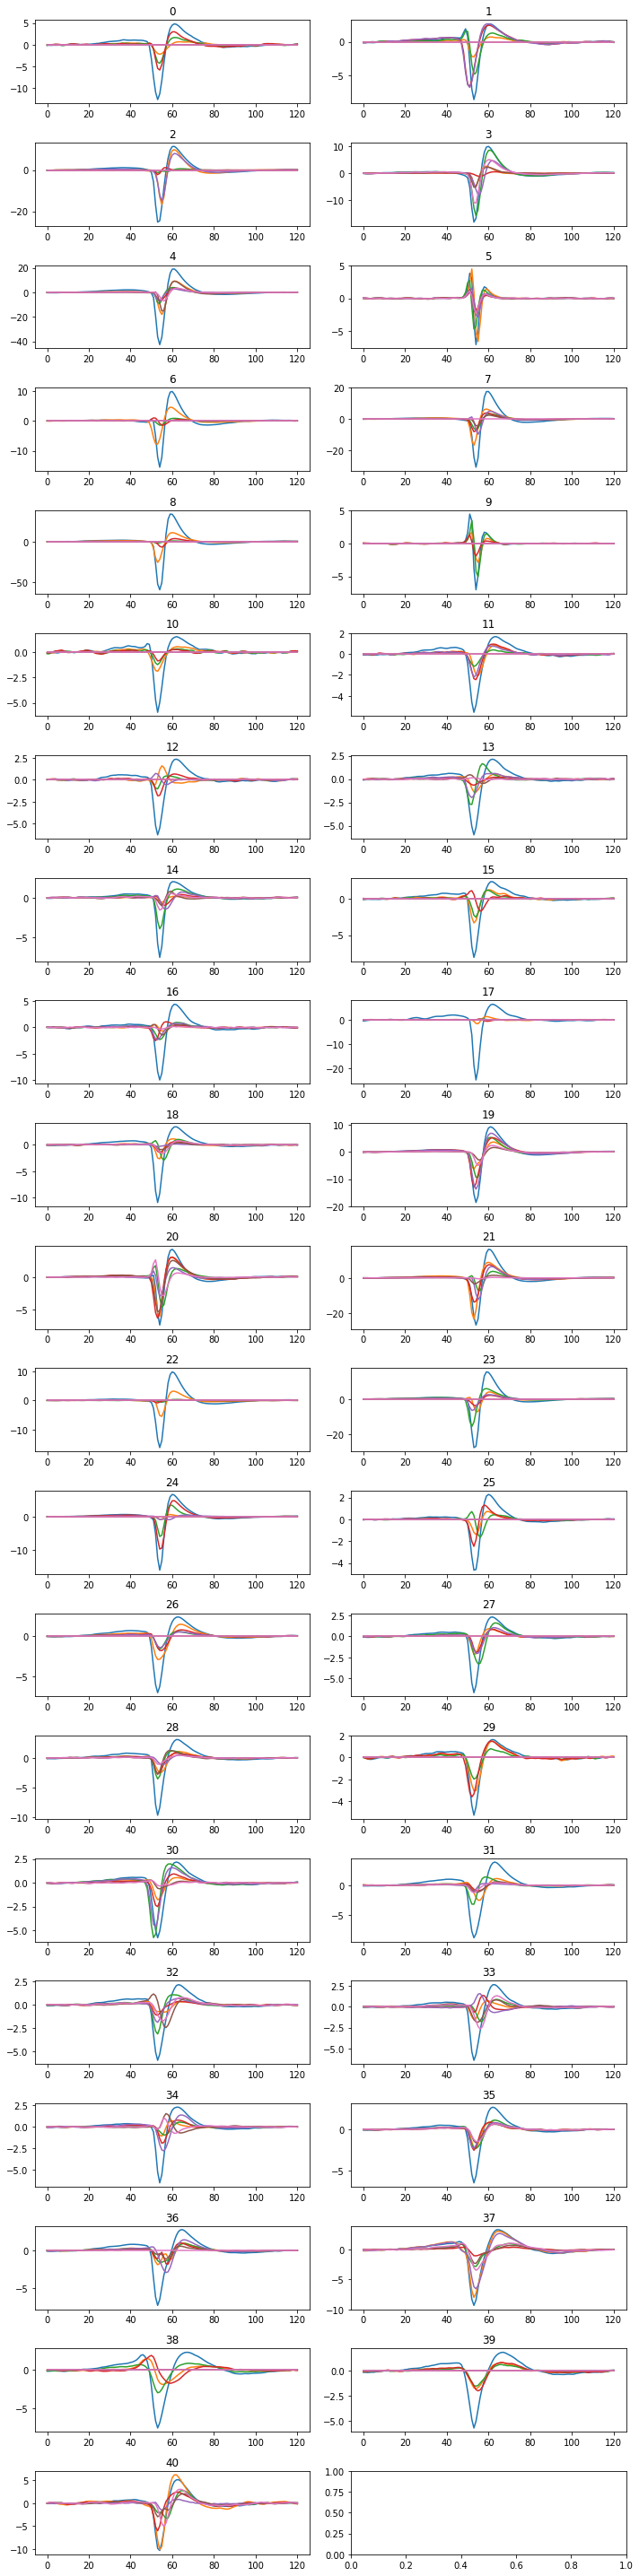

In [12]:
# this is just a handy plotting function, you don't actually
# need it
plot.grid_from_array(templates, axis=0, figsize=(10, 40),
                     max_cols=2)

## Generating training data

In [55]:
n_spikes = 20000
min_amplitude = 2
max_amp = 40
noise_ratio = 2
multi_channel = True

In [56]:
(x_detect, y_detect,
 x_triage, y_triage,
 x_ae, y_ae) = make.training_data(CONFIG, spike_train,
                                  chosen_templates_indexes,
                                  min_amplitude, max_amp, n_spikes,
                                  data_folder=path_to_experiment,
                                  multi_channel=True,
                                  noise_ratio=noise_ratio)

100%|██████████| 3/3 [00:14<00:00,  4.72s/it]


In [57]:
print(f'Training set sizes:\n\tdetect:{x_detect.shape}\n\ttriage:{x_triage.shape}\n\tautoencoder:{x_ae.shape}')

Training set sizes:
	detect:(100040, 41, 7)
	triage:(40016, 41, 7)
	autoencoder:(196176, 41)


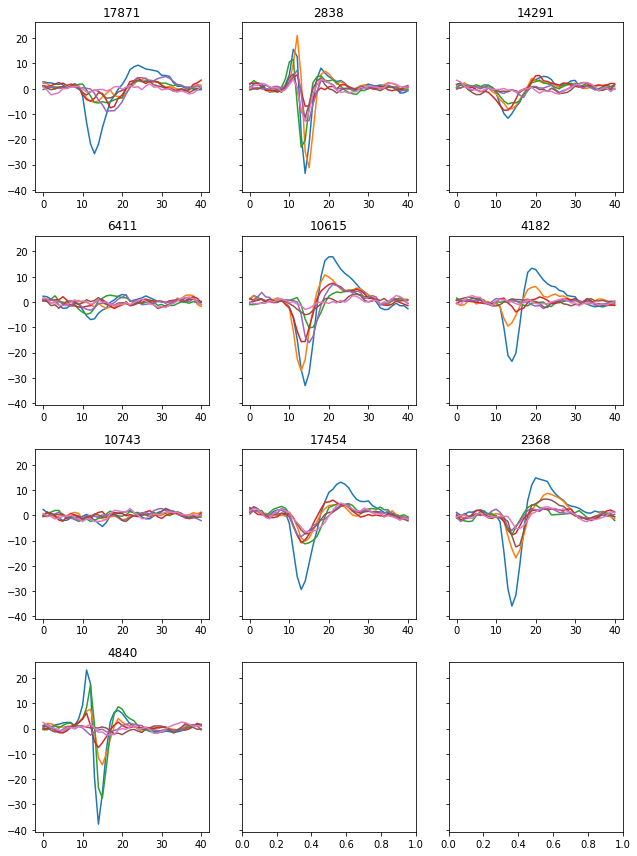

In [58]:
plot.grid_from_array(x_triage[y_triage == 1], axis=0,
                     elements=10,
                     auto_figsize=3, sharey=True)

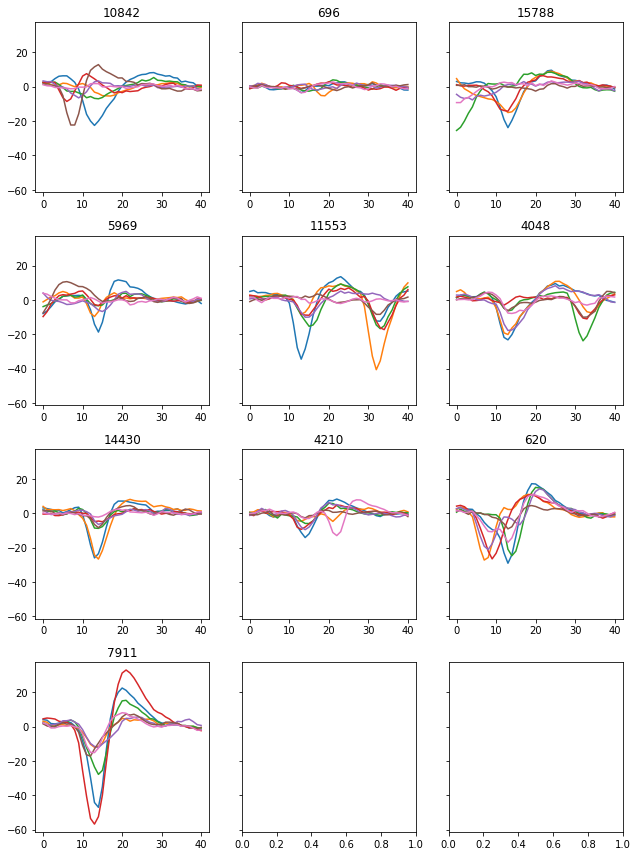

In [59]:
plot.grid_from_array(x_triage[y_triage == 0], axis=0,
                     elements=10,
                     auto_figsize=3, sharey=True)

# Load training data

NOTE: remove all above, will create separate notebooks for generating training data and then training,
this way I can compare models with the SAME training set, as oppose to creating new training sets
(even if the were created with the same parameters) - will also have to create a module to keep these
training sets organized (save metadata)

In [52]:
from os import path

# save training set
path_to_x = path.expanduser('/home/Edu/x_triage.npy')
path_to_y = path.expanduser('/home/Edu/y_triage.npy')

x_triage = np.load(path_to_x)
y_triage = np.load(path_to_y)

# Architecture

In [189]:
import keras

def make_model(x_train, input_shape):
    n_data, window_size, n_channels, _ = x_train.shape

    model = Sequential()
        
#     model.add(MaxPooling2D(pool_size=(2, 1), data_format="channels_last", padding='same'))
    
#     model.add(Dropout(0.75))

    model.add(Conv2D(10, kernel_size=(5, 5),
                     padding='same', activation='relu', use_bias=True,
                     data_format="channels_last", input_shape=input_shape))


#     model.add(Conv2D(70, kernel_size=(window_size, 1),
#                      padding='valid', activation='relu', use_bias=True,
#                      data_format="channels_last"))
    
    model.add(Conv2D(10, kernel_size=(5, 5),
                     padding='same', activation='relu', use_bias=True,
                     data_format="channels_last"))


#     model.add(Conv2D(70, kernel_size=(1, n_channels),
#                      padding='valid', activation='relu', use_bias=True,
#                      data_format="channels_last"))
    
    model.add(Conv2D(10, kernel_size=(5, 5),
                     padding='same', activation='linear', use_bias=True,
                     data_format="channels_last"))
        
#     model.add(MaxPooling2D(pool_size=(1, 2), data_format="channels_last", padding='same'))
#     model.add(Dropout(0.75))
    
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    model.summary()
    
    # initiate RMSprop optimizer
    opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
    opt = keras.optimizers.adam(lr=0.001)

    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model


# Training

In [190]:
import models
from sklearn.model_selection import train_test_split

x = x_triage[:, : , :, np.newaxis]

(x_train, x_test,
y_train, y_test) = train_test_split(x, y_triage, test_size=0.3)

_, wf, ch, _ = x_train.shape

m = make_model(x, (wf, ch, 1))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_111 (Conv2D)          (None, 41, 7, 10)         260       
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 41, 7, 10)         2510      
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 41, 7, 10)         2510      
_________________________________________________________________
flatten_34 (Flatten)         (None, 2870)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 2871      
Total params: 8,151
Trainable params: 8,151
Non-trainable params: 0
_________________________________________________________________


In [196]:
m.fit(x_train, y_train,
          batch_size=10000, epochs=50, shuffle=True,
          validation_data=(x_test, y_test))

Train on 49039 samples, validate on 21017 samples
Epoch 1/50
49039/49039 [==============================] - 2s 41us/step - loss: 0.0551 - acc: 0.9791 - val_loss: 0.0599 - val_acc: 0.9775
Epoch 2/50
49039/49039 [==============================] - 2s 39us/step - loss: 0.0536 - acc: 0.9799 - val_loss: 0.0606 - val_acc: 0.9773
Epoch 3/50
49039/49039 [==============================] - 2s 39us/step - loss: 0.0538 - acc: 0.9793 - val_loss: 0.0645 - val_acc: 0.9765
Epoch 4/50
49039/49039 [==============================] - 2s 39us/step - loss: 0.0535 - acc: 0.9796 - val_loss: 0.0627 - val_acc: 0.9769
Epoch 5/50
49039/49039 [==============================] - 2s 39us/step - loss: 0.0530 - acc: 0.9797 - val_loss: 0.0594 - val_acc: 0.9775
Epoch 6/50
49039/49039 [==============================] - 2s 39us/step - loss: 0.0520 - acc: 0.9801 - val_loss: 0.0597 - val_acc: 0.9774
Epoch 7/50
49039/49039 [==============================] - 2s 39us/step - loss: 0.0524 - acc: 0.9802 - val_loss: 0.0592 - val_acc

In [197]:
_ = 'triage-200-'+make_filename('h5')
print(_)
m.save(_)

triage-200-08-Aug-2018@18-27-15.h5


In [195]:
_ = 'triage-150-'+make_filename('h5')
print(_)
m.save(_)

triage-150-08-Aug-2018@18-25-29.h5


In [193]:
_ = 'triage-100-'+make_filename('h5')
print(_)
m.save(_)

triage-100-08-Aug-2018@18-23-45.h5
